# MovieLens: Collaborative Filtering

This notebook explores the concept of collaborative filtering recommender models using a basic nearest-neighbors method. We use the [Surprise Library](https://surprise.readthedocs.io/en/stable/index.html) to load and split data, as well as fit models. The central reference for the ideas explored here will be Arggawal, Charu C. - Recommender Systems, The Textbook.

# Setup

## Import Packages

In [16]:
import numpy as np
import pandas as pd
import surprise

import sys
sys.path.insert(1, "..")

from source_code.Python import get_data

In [57]:
df_ratings = get_data.get_movielens_small_ratings()
df_movies = get_data.get_movielens_small_movies()

In [58]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [59]:
df_ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

## Instantiate Objects

In [60]:
# instantiate Reader and Dataset objects; point to existing dataframe
reader_df = surprise.Reader(rating_scale = (1,5))
dataset_df = surprise.Dataset.load_from_df(df_ratings[["userId", "movieId", "rating"]], reader = reader_df)

# Collaborative Filtering

The basic idea behind **collaborative filtering** is to find groups of users with similar behaviors and use each behavior of one user in the group to predict the behavior of other users in the group. In this way, the user's "collaborate" to fill in the missing data. This specific idea is called **user-user** collaborative filtering.

The same logic can be used on items to find groups of items that are similar and to use this similarity to predict missing data; this specific idea is called **item-item** collaborative filtering.

# User-User Collaborative Filtering

## The Intuition

The best way to explain user-user collaborative filtering is with a toy example. Suppose we had the following matrix ratings:

In [43]:
users = ["Alice", "Bob"]

example_data = {
    "Movie 1" : [5, 4],
    "Movie 2" : [5, 4],
    "Movie 3" : [5, 5],
    "Movie 4" : [1, 2],
    "Movie 5" : [1, 1],
    "Movie 6" : [1, np.NAN]
}

df_example = pd.DataFrame(example_data, index = users)

df_example

,Movie 1,Movie 2,Movie 3,Movie 4,Movie 5,Movie 6
Alice,5,5,5,1,1,1.0
Bob,4,4,5,2,1,NaN


In this example, Alice and Bob rate movies 1 - 5 very similarly. Based on how similar they rate movies, we suspect Alice and Bob will probably rate Movie 6 very similarly as well. Since Alice already rated Movie 6 with a rating of 1, we can make an educated guess and say Bob will rate Movie 6 with a rating of 1.

In [46]:
# make educated guess that Bob's rating of movie 6 is equal to Alice's rating of Movie 6
# based on how similar they are
guess_bob_movie_6 = df_example.loc["Alice", "Movie 6"]

# fill in missing rating with guess
df_example.loc["Bob", "Movie 6"] = guess_bob_movie_6

df_example

,Movie 1,Movie 2,Movie 3,Movie 4,Movie 5,Movie 6
Alice,5,5,5,1,1,1.0
Bob,4,4,5,2,1,1.0


This technique for using Alice's rating to guess Bob's rating is precisely user-user collaborative filtering.

This idea also generalizes to 3 or more users and its power also becomes more apparant.

In [55]:
users = ["Alice", "Bob", "Chris"]

example_data = {
    "Movie 1" : [5, 4, 5],
    "Movie 2" : [np.NaN, np.NaN, 5],
    "Movie 3" : [5, 5, 5],
    "Movie 4" : [1, 2, 2],
    "Movie 5" : [1, 1, 1],
    "Movie 6" : [1, np.NAN, np.NaN]
}

df_example = pd.DataFrame(example_data, index = users)

df_example

,Movie 1,Movie 2,Movie 3,Movie 4,Movie 5,Movie 6
Alice,5,NaN,5,1,1,1.0
Bob,4,NaN,5,2,1,NaN
Chris,5,5.0,5,2,1,NaN


In this example, Alice, Bob, and Chris all seem to rate movies in a similar fashion. Our natural instinct is to use each user's rating to fill in the missing data.

Alice and Bob are both missing a rating for Movie 2, but since Charlie is pretty similar to both Alice and Bob, we can use Chris' rating to fill in the missing data.

Bob and Chris are both missing a rating for Movie 6, but since Alice is pretty similar to both Bob and Chris, we can use Alice's rating to fill in the missing data.

In [56]:
# make educated guess on Alice and Bob rating of Movie 2
# based on similarity with Chris
guess_movie_2 = df_example.loc["Chris", "Movie 2"]

# make educated guess on Bob and Chris rating of Movie 2
# based on similarity with Alice
guess_movie_6 = df_example.loc["Alice", "Movie 6"]

# fill in missing ratings with guesses
df_example.loc["Alice", "Movie 2"] = guess_movie_2
df_example.loc["Bob", "Movie 2"] = guess_movie_2

df_example.loc["Bob", "Movie 6"] = guess_movie_6
df_example.loc["Chris", "Movie 6"] = guess_movie_6

df_example

,Movie 1,Movie 2,Movie 3,Movie 4,Movie 5,Movie 6
Alice,5,5.0,5,1,1,1.0
Bob,4,5.0,5,2,1,1.0
Chris,5,5.0,5,2,1,1.0


Notice that the 3 users essentially "cover" each other's gaps, hence the name "Collaborative Filtering".

## The Theory

The example above is useful for developing the intuition, but it's not immediately obvious how we would automate this whole process with a machine. There are 2 central questions we have to answer in order to achieve machine automation.

1) Given any two users Alice and Bob, how do we determine if Alice and Bob are similar? In fact, given any user U, how do we find the users most similar to U?

2) Once we find users most similar to user U, how do we construct a guess for User U's missing ratings?

Question 1 is the elephant in the room: we need a way to quantify the "similarity" between two users in order to determine how the missing ratings get filled.

Question 2 is a bit more subtle: given user U, what happens if multiple user's are tied in their similarility to user U? What happens if all the similar users are also missing the same ratings as User U?

## Similarity Scores

Given two users A and B, we wish to quantify their similarity. Intuitively, two user's are more "similar" if they rate the same movies with approximately the same scores. Users are considered less similar if they rate the same movies with very different scores.

This vague definition actually motivates a mathematically rigorous definition. Suppose we had two users A and B. Let $M_{A,B}$ be the set of movies that have been rated by both user A and user B.
Since $M_{A,B}$ contains all the movies rated by user A and user B, we can write down the ratings of user A and user B on this common set of movies. Represent these ratings on $M_{A,B}$ using the vectors:

$$r_A = [a_1, \ldots, a_n]$$
$$r_B = [b_1, \ldots, b_n]$$

User A and user B are considered "similar" if the values in these two vectors are roughly the same. Since vectors can be thought of arrows in space, the values of the vectors are approximately the same precisely when the arrows are "near" each other. Thus we can just define **similarity** as the distance between the vectors $r_A$ and $r_B$.

Now, there are 3 possible ways to measure distance between vectors.

1) **Euclidean distance** measures the distance between the points defined by vectors $r_A$ and $r_B$.
$$Sim(A,B) = |r_A - r_B| = \sqrt{(a_1 - b_1)^2 + \ldots + (a_n - b_n)^2}$$

2) **Cosine distance** measures the angle between the vectors $r_A$ and $r_B$.

$$Sim(A,B) = Cos(r_A, r_B) = \frac{r_A \cdot r_B}{|r_A| |r_b|}$$

3) **Pearson Correlation** measures how often the values rise and fall together

$$Sim(A,B) = Pearson(r_A, r_B) = \frac{\sum_{i=1}^n (a_i - \overline{a})(b_i-\overline{b})}{\sqrt{\sum_{i=1}^n(a_i - \overline{a})^2}\sqrt{\sum_{i=1}^n(b_i - \overline{b})^2}}$$

### Minimum Sample Sizes

We thus have 3 possible ways of measuring distance and all are equally valid. However, for Euclidean and Cosine distance, there is a very subtle edge case we need to be aware of.

Suppose users A, B, and C has the following ratings data:

In [80]:
df_example = pd.DataFrame(
    columns = ["Movie 1", "Movie 2", "Movie 3", "Movie 4", "Movie 5"],
    index = ["A", "B", "C"]
)

df_example.iloc[0, 0:5] = [5, 5, 4, 1, 1]
df_example.iloc[1, 0:5] = [5, 4, 4, 1, 1]
df_example.iloc[2, 0] = 5

df_example

,Movie 1,Movie 2,Movie 3,Movie 4,Movie 5
A,5,5,4,1,1
B,5,4,4,1,1
C,5,NaN,NaN,NaN,NaN


Before even doing any computations, we notice that user A and user B are nearly identical in all 5 movie ratings, so A and B should be most similar. 

Let's use cosine distance to measure the similarities between the users. By definition only the ratings for movies that A and B have rated are used. Since A and B both rated all 5 movies, we use all the values:

$$Sim(A,B) = Cos(r_A, r_B) = \frac{r_A \cdot r_B}{|r_A| |r_b|}$$

In [87]:
r_A = np.array([5, 5, 4, 1, 1])
r_B = np.array([5, 4, 4, 1, 1])

sim_AB = np.dot(r_A, r_B)/(np.linalg.norm(r_A) * np.linalg.norm(r_B))

sim_AB

0.9946266402723094

Therefore:

$$Sim(A, B) = 0.995$$

Now let's measure the cosine distance between A and C. Again, the definition requires us to use the movies that have been rated by both A and C. But since Movie 1 is the only such movie, that is the only score we use in the computation:

$$Sim(A,C) = Cos(r_A, r_C) = \frac{5 \cdot 5}{|5| |5|} = 1$$

In particular, $Sim(A,C)$ is **greater** than $Sim(A,B)$, so our method for measuring similarity would return user C as most similar to user A. 

This is problematic because we know this is unreasonable. User C was most similar to user A because they just so happen to rate 1 single movie exactly the same. There is a very high probability that this similarity happend out of random chance.

On the other hand, user B rated all 5 movies nearly identically to user A, so there is a much more evidence to suggest that user B is most similar to user A.

The issue being highlighted here is similarity measures tend to be skewed by users that have very few ratings. For this reason, we often need to enforce a **minimum sample size** when measuring similarity between users. For example, we could stipulate that similarity scores $Sim(A, X)$ are only valid when the users have at rated at least 4 movies together. This would disqualify the score $Sim(A,C)$ and allow $Sim(A,B)$ to be the only valid score.

## Prediction Function

Now that we can measure similarity between users, the next question we must answer is how to predict a user's rating. That is, given user U and movie $j$, we wish to predict $r_{uj}$.

### The Simple Approach

The simplest idea we can think of is to find a user V for which $Sim(U,V)$ is the highest. This is the most similar user to user U. Then for any given movie $j$ we want to predict user U's rating for movie $j$ by using V's rating for movie $j$. That is, our prediction $\hat{r_{uj}}$ is just:

$$\hat{r_{uj}} := r_{vj}$$

This idea is very simple, but there are a few problems. Namely:

1) What if user V is also missing a rating for movie $j$?

2) What if user U and user V just so happen to have very different opinions about movie $j$?


### The Better Approach: $k$-Nearest Neighbors

There isn't a way to fully eliminate either of these problems, but we can mitigate them to some extent by enlarging our pool of similar users. Specifically, instead of looking for the 1 most similar user, we can instead look for the top 30 (or however many) most similar users.

1) This mitigates problem 1 because it is much less likely that all 30 users are missing a rating for movie $j$.

2) This also mitigates problem 2 because a weighted average of 30 user's is more robust estimate, i.e. less influenced by random chance.

So to make a prediction, let $N^k(U)$ be the set of the top $k$ most similar users to user U. Since similarity is based on distance, the most similar users are the "closest neighbors" to user U. For this reason, the users in $N^k(U)$ are called the **$k$-nearest neighbors** of user U. 

Since we want to make a prediction on movie $j$, we can only use the neighbors $N_j^k(U)$ of users that actually have rated movie $j$. Then our prediction for user U's rating on movie $j$ is given by the weighted average:

$$
\hat{r_{uj}} = \frac{\sum_{v\in N_j^k(U)} Sim(U,V) \cdot r_{vi}}{\sum_{v\in N_j^k(U)} Sim(U,V)}
$$

Notice that this is a weighted average with the similarity scores being used as the weights. This actually makes perfect sense, since we want more similar users to be given more importance.

This $k$-nearest neighbors prediction model can be implemented using the Suprise library very easily.

In [91]:
# specify how we want to measure similarity
sim_options = {
    "name" : "cosine",   # specifies cosine similarity
    "min_support" : 5,   # disqualifies any sim. scores based on less than 5 movies in common
    "user_based" : True, # specifies user-user collab filtering
}

# train-test split; 75% to train and 25% to test
trainset, testset = surprise.model_selection.train_test_split(dataset_df, test_size = 0.25)

# instantiate k-nearest neighbors model
model_KNNBasic = surprise.prediction_algorithms.knns.KNNBasic(
    k = 30,      # use 30 nearest neighbors
    min_k = 1,   # minimum number of neighbors necessary to make a prediction
    sim_options = sim_options, 
    verbose = True
)

In [124]:
# fit model; automatically computes similarity matrix first
model_KNNBasic.fit(trainset)

# evaluate model MSE on test set
surprise.accuracy.mse(
    model_KNNBasic.test(testset),
    verbose = True
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
MSE: 0.9576


0.9575910113134967

The model is fit by first computing the matrix of user-user similarity scores. This matrix of similarity scores stores all the necessary data needed to make a prediction any givne user in matrix.

We can check some of the similarity scores by picking a user contained in `trainset` and calling the `KNNBasic.get_neighbors()`

In [102]:
# check if User 1 is in the training set
trainset.knows_user(1)

True

In [104]:
# look at some of User 1's ratings in the training set
trainset.ur[1][0:5]

[(1, 2.5), (21, 2.0), (38, 4.0), (190, 2.5), (266, 3.0)]

In [107]:
# get the 30 nearest neighbors to User 1
# based on Sim. matrix computed from training set
print(model_KNNBasic.get_neighbors(1, 30))

[213, 505, 558, 606, 588, 573, 258, 493, 424, 603, 568, 371, 440, 527, 456, 185, 85, 249, 584, 143, 408, 507, 547, 381, 228, 388, 604, 229, 590, 248]


Based on the specifications of the model, User 213 is the most similar to User 1, followed by User 505, 558, etc.

These similarity scores are stored in a matrix in the `KNNBasic.sim` attribute. We can access the similarity scores for User 1 by directly indexing the matrix `KNNBasic.sim`

In [115]:
# look at similarity scores between user 1 and 100 other users
model_KNNBasic.sim[1][1:100]

array([1.        , 0.95130083, 0.90926338, 0.91952748, 0.96007409,
       0.93156728, 0.93798816, 0.9488257 , 0.90938726, 0.94107136,
       0.93108071, 0.9724034 , 0.94015282, 0.94460138, 0.93348199,
       0.93814725, 0.96981794, 0.89521383, 0.90751146, 0.96748545,
       0.90176999, 0.94205786, 0.96640729, 0.95798527, 0.94918384,
       0.87430389, 0.92020642, 0.92456858, 0.94893108, 0.97164808,
       0.94121299, 0.96058857, 0.95862437, 0.94840874, 0.92232512,
       0.93820817, 0.9490064 , 0.95645982, 0.93349271, 0.92734198,
       0.94571065, 0.95698427, 0.9340402 , 0.96283235, 0.97054113,
       0.92741481, 0.94941908, 0.93642143, 0.94112604, 0.92336114,
       0.94742269, 0.94627292, 0.93342912, 0.97690585, 0.95681107,
       0.92262478, 0.96584128, 0.9486426 , 0.95724316, 0.92226592,
       0.96074001, 0.97634357, 0.95931829, 0.95539218, 0.95917589,
       0.95878875, 0.90590314, 0.95396484, 0.95733592, 0.91907018,
       0.9557489 , 0.95874286, 0.97030256, 0.95961967, 0.91803

In [118]:
# look at the similarity scores between user 1 and their 30 nearest neighbors
neighbors = model_KNNBasic.get_neighbors(1, 30)

neighbors_scores = [model_KNNBasic.sim[1][n] for n in neighbors]

print(neighbors_scores)

[1.0, 1.0, 1.0, 1.0, 0.9954163242264943, 0.9932038011148655, 0.9931673187118063, 0.9928015930030369, 0.9925779735446323, 0.9921727569637341, 0.9920514138054163, 0.9918466774740248, 0.990928672430378, 0.990555317673597, 0.9903334353567688, 0.9902112160125253, 0.9901725976033663, 0.9897201797934381, 0.9877147365184785, 0.9876749705890591, 0.9876658701037219, 0.9872831817472322, 0.9872699029731293, 0.9872277834611144, 0.9870263204945258, 0.9865952324308038, 0.986127776752739, 0.9856474484755007, 0.9855467571685562, 0.9846761363548681]


User 1's ratings on any given movie will then be a weighted average of these 30 neighbors, with the similarity scores being the weights.

In [159]:
# get movieId for Star Wars: The Phantom Menace
df_movies[ df_movies['title'].str.contains("The Phantom Menace")]

,movieId,title,genres
2544,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi


In [160]:
# check of User 1 has a rating for Phantom Menace
movie = 2628

df_ratings[ (df_ratings["userId"] == 1) & (df_ratings["movieId"] == movie) ]

,userId,movieId,rating,timestamp
171,1,2628,4.0,964980523


In [161]:
# check global average rating for Phantom Menace
df_ratings[df_ratings["movieId"] == movie]["rating"].mean()

3.107142857142857

In [162]:
# predict User 1's rating for Phantom Menace
model_KNNBasic.predict(uid = 1, iid = movie, clip = False, verbose = True)

user: 1          item: 2628       r_ui = None   est = 3.42   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=1, iid=2628, r_ui=None, est=3.4183670528659533, details={'actual_k': 30, 'was_impossible': False})

We see that the global average for Star Wars: The Phantom Menace is 3.1 while User 1's rating of the Phantom Menace is 4.0; User 1 likes The Phantom Menace more so than the average population of users. The model predicts User 1's rating to be 3.4 (which is higher than the population average), so we see that the model is able to capture some of User 1's liking for the Phantom Menace!

Unfortunately, the model is still off by about 0.6, which is a whole half-point in ratings. Checking User 1's distribution of ratings reveals a possible reason for why the model is off:

array([[<AxesSubplot: title={'center': 'rating'}>]], dtype=object)

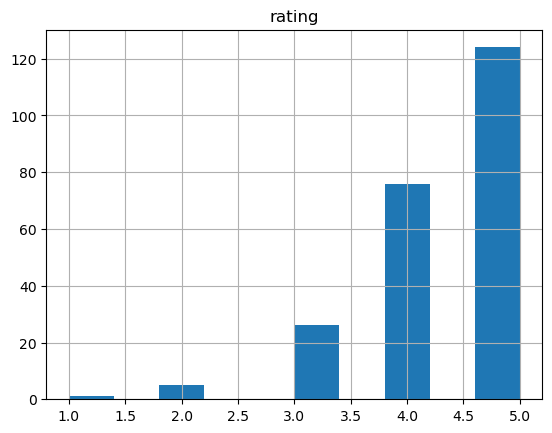

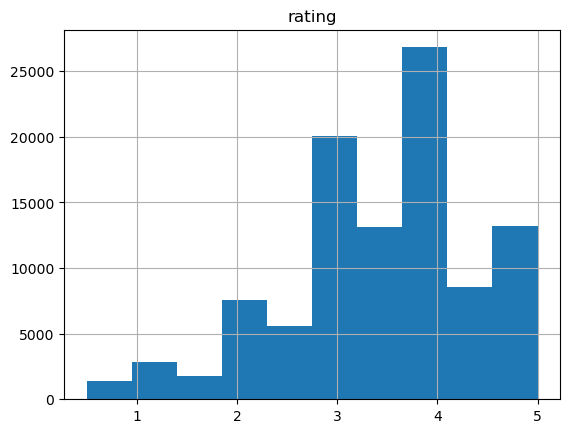

In [166]:
df_ratings[ df_ratings["userId"] == 1 ].hist(column = "rating")

df_ratings.hist(column = "rating")

User 1's ratings are heavily skewed to the right; this user has a natural tendency to give movies 4-5 stars. The histogram reveals that user 1 is likely grading on a more generous scale than the average population. Unfortunately, since our nearest neighbor model computes User 1's ratings based off others in the population, User 1's more generous grading scale is not accurately accounted for by the model. 

## The Best Approach: $k$-Nearest Neighbors With Mean Centering

As mentioned in the previous section, a basic $k$-nearest neighbors model isn't able to fully capture a user's natural grading scale. However, accounting for this piece of variance is actually really simple. We can keep the $k$-nearest neighbors approach of finding the set $N^k(U)$ of $k$-nearest neighbors to user U, but will slightly augment the prediction function:

$$
\hat{r_{uj}} = \mu_u + \frac{\sum_{v\in N_j^k(U)} Sim(U,V) \cdot (r_{vi} - \mu_v)}{\sum_{v\in N_j^k(U)} Sim(U,V)}
$$

What we are doing here is changing the prediction function to predict the expected deviation above or below the User U's baseline mean. We the add this expected deviation on top of User U's baseline mean $\mu_u$ to get the final predicted rating.

In [167]:
# specify how we want to measure similarity
sim_options = {
    "name" : "cosine",   # specifies cosine similarity
    "min_support" : 5,   # disqualifies any sim. scores based on less than 5 movies in common
    "user_based" : True, # specifies user-user collab filtering
}

# train-test split; 75% to train and 25% to test
trainset, testset = surprise.model_selection.train_test_split(dataset_df, test_size = 0.25)

# instantiate k-nearest neighbors model
model_KNNWithMeans = surprise.prediction_algorithms.knns.KNNWithMeans(
    k = 30,      # use 30 nearest neighbors
    min_k = 1,   # minimum number of neighbors necessary to make a prediction
    sim_options = sim_options, 
    verbose = True
)

In [168]:
# fit model; automatically computes similarity matrix first
model_KNNWithMeans.fit(trainset)

# evaluate model MSE on test set
surprise.accuracy.mse(
    model_KNNWithMeans.test(testset),
    verbose = True
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
MSE: 0.8012


0.8011882362468549

In [169]:
# predict User 1's rating for Phantom Menace
model_KNNWithMeans.predict(uid = 1, iid = movie, clip = False, verbose = True)

user: 1          item: 2628       r_ui = None   est = 4.12   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=1, iid=2628, r_ui=None, est=4.124571719110307, details={'actual_k': 30, 'was_impossible': False})

Notice that this model predict User 1's rating for The Phantom Menace to be 4.1 which is very close to User 1's true rating of 4.0 because the model is now account for User 1's natural tendency to give out high ratings!